In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from ampligraph.latent_features import TransE,DistMult, ComplEx
from ampligraph.evaluation import evaluate_performance, mrr_score, hits_at_n_score
import random as rn
import tensorflow as tf
from sklearn.decomposition import PCA
from rdflib import Graph
import os

SEED = 123
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
np.random.seed(SEED)
rn.seed(SEED)
tf.set_random_seed(SEED)

/opt/anaconda3/envs/ampligraph/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/ampligraph/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/ampligraph/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/ampligraph/lib/python3.6/site-packages

In [2]:
g=Graph()
g.parse("/Users/nhalliwe/Desktop/CORESE-DATA/human-data.rdf", format="xml")

<Graph identifier=Na39e7da696714310bdd93f7d8c130ef9 (<class 'rdflib.graph.Graph'>)>

In [3]:
triples = []

for i,j,k in g:
    
    head = str(i).split('#')
    rel = str(j).split('#')
    tail = str(k).split('#')
    
    if head[0] == 'http://www.inria.fr/2015/humans-instances':
        
        triples.append((head[-1], rel[-1], tail[-1]))

X = np.array(triples)

In [4]:
X

array([['Eve', 'type', 'Person'],
       ['Eve', 'name', 'Eve'],
       ['John', 'shoesize', '14'],
       ['Alice', 'hasFriend', 'John'],
       ['Mark', 'name', 'Mark'],
       ['John', 'type', 'Person'],
       ['Eve', 'hasFriend', 'Alice'],
       ['John', 'age', '37'],
       ['Jack', 'name', 'Jack'],
       ['Jennifer', 'type', 'Woman'],
       ['David', 'type', 'Researcher'],
       ['Flora', 'name', 'Flora'],
       ['Mark', 'hasFather', 'John'],
       ['Mark', 'age', '14'],
       ['Eve', 'type', 'Lecturer'],
       ['Eve', 'hasSpouse', 'David'],
       ['Alice', 'name', 'Alice'],
       ['Harry', 'hasSpouse', 'Sophie'],
       ['Flora', 'age', '95'],
       ['Harry', 'age', '25'],
       ['Alice', 'type', 'Woman'],
       ['Laura', 'hasFriend', 'Alice'],
       ['David', 'name', 'David'],
       ['Mark', 'shoesize', '8'],
       ['Laura', 'type', 'Person'],
       ['Mark', 'trouserssize', '36'],
       ['Flora', 'type', 'Woman'],
       ['Harry', 'phoneNumber', '32 08 98'],


In [5]:
# entities = list(set(np.hstack((data[:,0],data[:,2]))))
# relations = list(set(data[:,1]))

# num_ent = len(entities)
# num_rel = len(relations)
# adj = np.zeros(shape=(num_ent,num_rel, num_ent))
# for h,r,t in triples:
    
#     head_idx = entities.index(h)
#     rel_idx = relations.index(r)
#     tail_idx = entities.index(t)
    
#     adj[head_idx, rel_idx, tail_idx] = 1

In [6]:
all_relations = np.unique(X[:,1])
all_entities = np.unique(np.concatenate((X[:,0], X[:,2]), axis=0))

In [7]:
model = DistMult(batches_count=1, seed=SEED, epochs=200, k=10, loss='pairwise',
               loss_params={'margin':2})

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


In [8]:
model.fit(X)

WARNING - From /opt/anaconda3/envs/ampligraph/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
WARNING - From /opt/anaconda3/envs/ampligraph/lib/python3.6/site-packages/tensorflow/python/data/ops/dataset_ops.py:429: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
WARNING - From /opt/anaconda3/envs/am

In [9]:
scores = []

for rel in all_relations:
    
    score = model.predict(np.array(['Jennifer', rel, 'John']))
    scores.append((rel, score[0]))

In [10]:
sorted(scores, key=lambda x:x[1], reverse=True)

[('hasSpouse', 0.073922485),
 ('hasFather', 0.067849055),
 ('phoneNumber', 0.043874886),
 ('type', 0.039827768),
 ('trouserssize', 0.039557174),
 ('shirtsize', 0.038723297),
 ('hasFriend', 0.024114676),
 ('name', 0.008760466),
 ('age', -0.010884944),
 ('hasChild', -0.051799472),
 ('shoesize', -0.11262773)]

In [11]:
all_entity_embeddings = []
entity_labels = []

for i in all_entities:
    
    all_entity_embeddings.append(model.get_embeddings([i],embedding_type='entity'))
    entity_labels.append(i)
    
all_entity_embeddings = np.array(all_entity_embeddings).squeeze()

In [12]:
all_relation_embeddings = []
relation_labels = []

for i in all_relations:
    
    all_relation_embeddings.append(model.get_embeddings([i],embedding_type='relation'))
    relation_labels.append(i)
    
all_relation_embeddings = np.array(all_relation_embeddings).squeeze()

In [13]:
full = np.concatenate((all_entity_embeddings, all_relation_embeddings))
full_labels = np.concatenate((all_entities,all_relations))

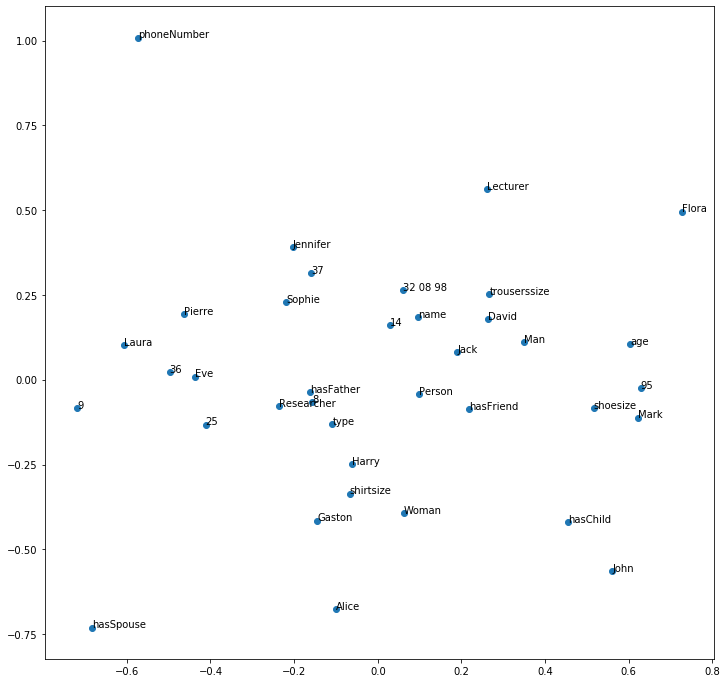

In [14]:
embeddings_2d = PCA(n_components=2, random_state=333).fit_transform(full)
fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(embeddings_2d[:,0], embeddings_2d[:,1])
for i, txt in enumerate(full_labels):
    ax.annotate(txt, (embeddings_2d[i, 0], embeddings_2d[i, 1]))

In [15]:
np.savez('./data/human_data.npz', 
         relations=relation_labels,
         relation_embeddings=all_relation_embeddings,
         entities=entity_labels,
         entity_embeddings=all_entity_embeddings,
         X=X,
        )

In [16]:
# for h,r,t in X:
#     if h=='Laura' or t=='Laura':
#         print(h,r,t)

Laura hasFriend Alice
Laura type Person
Laura name Laura
